# 竞争实验在实验室中常被用来检测
例如某种突变体相对于野生型菌株的适应度。在这里，我们模拟了一个这样的实验，涉及到大肠杆菌及其一种非必需但有害的突变——从糖酵解途径中删除己糖磷酸异构酶反应。在这种竞争排除实验中，通过连续传代的方式观察突变株与野生型菌株的竞争表现。

# 加载模型并创建突变体
首先，我们加载“核心”大肠杆菌模型，并通过将己糖磷酸异构酶反应的上下界均设置为零来创建突变体。接着，我们将原始模型和突变体模型都添加到我们的试管环境布局中。

In [1]:
# Start by loading required packages, including the COMETS toolbox
import cometspy as c
import cobra.io
import pandas as pd
import matplotlib.pyplot as plt

# load the models and perform the mutation
wt = c.model(cobra.io.load_json_model("iJO1366.json"))
wt.id = 'wt'
mut = c.model(cobra.io.load_json_model("iJO1366.json"))
mut.change_bounds('TPI', 0,0)
mut.id = 'TPI_KO'

# set its initial biomass, 5e-6 gr at coordinate [0,0]
wt.initial_pop = [0, 0, 5e-8]
mut.initial_pop = [0, 0, 5e-8]

C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:623: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.smat = pd.concat([self.smat, cdf])
C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:636: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  self.objective = [int(self.reactions[self.reactions.
C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\model.py:623: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclud

# 创建布局、添加模型和设置媒体合成
我们创建一个空布局（“test_tube”）并设置初始营养供应。

In [2]:
# create an empty layout
test_tube = c.layout()

# add the models to the test tube
test_tube.add_model(wt)
test_tube.add_model(mut)

C:\Users\99374\.conda\envs\CarveMe\Lib\site-packages\cometspy\layout.py:1361: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.media = pd.concat([self.media, new_row],


building empty layout model
models will need to be added with layout.add_model()


设置培养基组成，向其中添加葡萄糖以及该模型所需的无机营养物质（如氨、磷酸盐）和氧气。在模拟中，这些无机营养物质被视为“静态”的，它们的值设为1000，并且永远不会耗尽。在COMETS模拟中，将代谢物视为“静态”是一种模拟无限供应代谢物的方法。

In [3]:
# Add glucose to the media 
test_tube.set_specific_metabolite('glc__D_e', 0.01)

# Add typical trace metabolites and oxygen coli as static
trace_metabolites = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e', 'h_e', 'k_e', 'h2o_e', 'mg2_e',
                     'mn2_e', 'mobd_e', 'na1_e', 'ni2_e', 'nh4_e', 'o2_e', 'pi_e', 'so4_e', 'zn2_e']

for i in trace_metabolites:
    test_tube.set_specific_metabolite(i, 1000)
    test_tube.set_specific_static(i, 1000)

# 设置仿真参数
接下来，我们创建一个参数对象并修改所需的参数 - 在本例中，仅修改模拟运行的周期数。

In [4]:
comp_params = c.params()
comp_params.set_param('maxCycles', 240)

# 运行模拟
最后，我们使用上面创建的布局和参数创建comets对象，并运行竞争分析。

In [5]:
comp_assay = c.comets(test_tube, comp_params)
comp_assay.run()


Running COMETS simulation ...
Done!


我们现在绘制了这两种基因型在共培养中的生物量。

Text(0, 0.5, 'Biomass (gr.)')

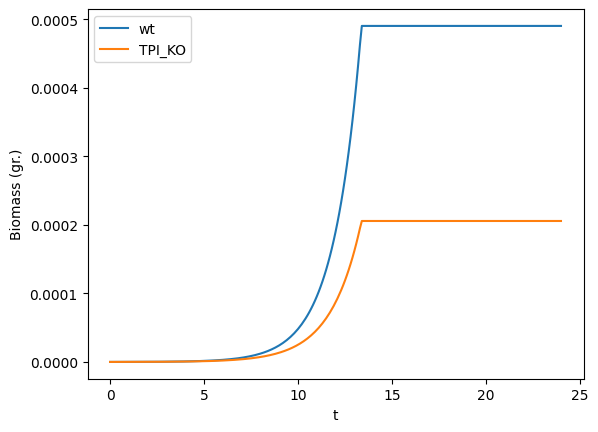

In [6]:
biomass = comp_assay.total_biomass
biomass['t'] = biomass['cycle'] * comp_assay.parameters.all_params['timeStep']

myplot = biomass.drop(columns=['cycle']).plot(x = 't')
myplot.set_ylabel("Biomass (gr.)")

我们可以对结果进行定量分析。例如，我们可以计算突变体相对于野生型的竞争适应度，即突变体的生物量增加除以野生型的生物量增加的比率：

In [7]:
cfit = (biomass.loc[biomass['t'] == 24, 'TPI_KO'].iloc[0]/biomass.loc[biomass['t'] == 0, 'TPI_KO'].iloc[0])/(biomass.loc[biomass['t'] == 24, 'wt'].iloc[0]/biomass.loc[biomass['t'] == 0, 'wt'].iloc[0])
cfit

0.41951819616503444

# 模拟串行传输
利用COMETS工具，我们还可以模拟这两种突变体之间的连续转移竞争。我们只需调整参数，增加总的模拟时间，并在每24小时设置一次1%的小批量转移，但我们将沿用之前的test_tube环境布局。

In [8]:
serial_params = c.params()
serial_params.set_param('maxCycles', 240*25) # simulate 4 serial transfers of 24h each
serial_params.set_param('batchDilution', True)
serial_params.set_param('dilFactor', 0.01)
serial_params.set_param('dilTime', 24)

我们运行模拟

In [9]:
serial_expt = c.comets(test_tube, serial_params)
serial_expt.JAVA_CLASSPATH = comp_assay.JAVA_CLASSPATH
serial_expt.run()


Running COMETS simulation ...
Done!


现在绘制实验期间两个物种的生物量

Text(0, 0.5, 'Biomass (gr.)')

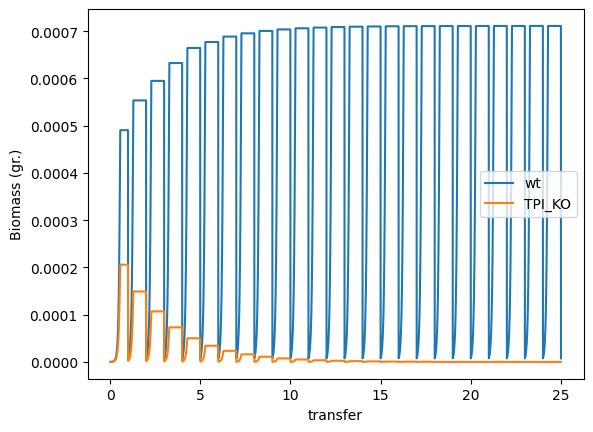

In [10]:
biomass = serial_expt.total_biomass
biomass['transfer'] = biomass['cycle'] * comp_assay.parameters.all_params['timeStep']/24

myplot = biomass.drop(columns=['cycle']).plot(x = 'transfer')
myplot.set_ylabel("Biomass (gr.)")